Here we start with the importing of our libraries and overall setup for our analysis of Air 12305

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr


We will now load our dataset and get a basic overview of it's contents as well as a peak at the first 5 entries



In [77]:
df = pd.read_csv(
    r"D:\Downloads\air_12305.txt", 
    sep=",", #specify the separator used in the file
    on_bad_lines="skip"   #this is to skip bad lines in the CSV file
)
  
print(df.info())
print(df.head())
print(df.describe())
print(df.isnull().sum())
# this is where we check for missing values
print(f"Missing values: {df['ptot_watt'].isnull().sum()}")
print(f"Total records: {len(df)}")

# this is where we check data range
print(f"Date range: {df['time'].min()} to {df['time'].max()}")

# here we take a look at the basic statistics of our ptot_watt column
print(df['ptot_watt'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561924 entries, 0 to 561923
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          561924 non-null  int64  
 1   time                        561924 non-null  object 
 2   epoch                       561924 non-null  int64  
 3   air                         561924 non-null  int64  
 4   device                      561924 non-null  int64  
 5   freq_hertz                  561924 non-null  int64  
 6   vlineavg_volt               561924 non-null  int64  
 7   va_volt                     557924 non-null  float64
 8   vb_volt                     557924 non-null  float64
 9   vc_volt                     557924 non-null  float64
 10  vlineper_volt               557924 non-null  float64
 11  ia_ampere                   557924 non-null  float64
 12  ib_ampere                   557924 non-null  float64
 13  ic_ampere     

Now we will perform the exploratory data analysis (EDA)


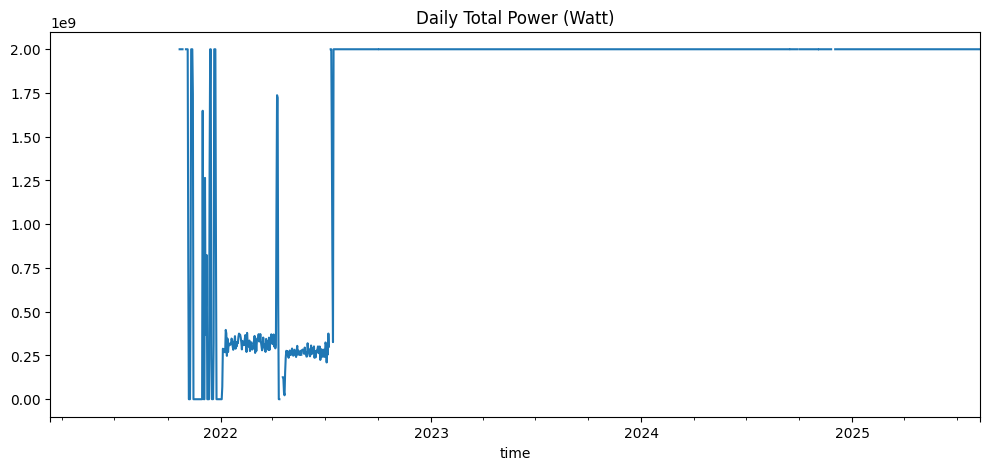

C:\Users\shait\AppData\Local\Temp\ipykernel_25964\3881932909.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('time')['ptot_watt'].resample('M').mean().plot(ax=axes[1,0])


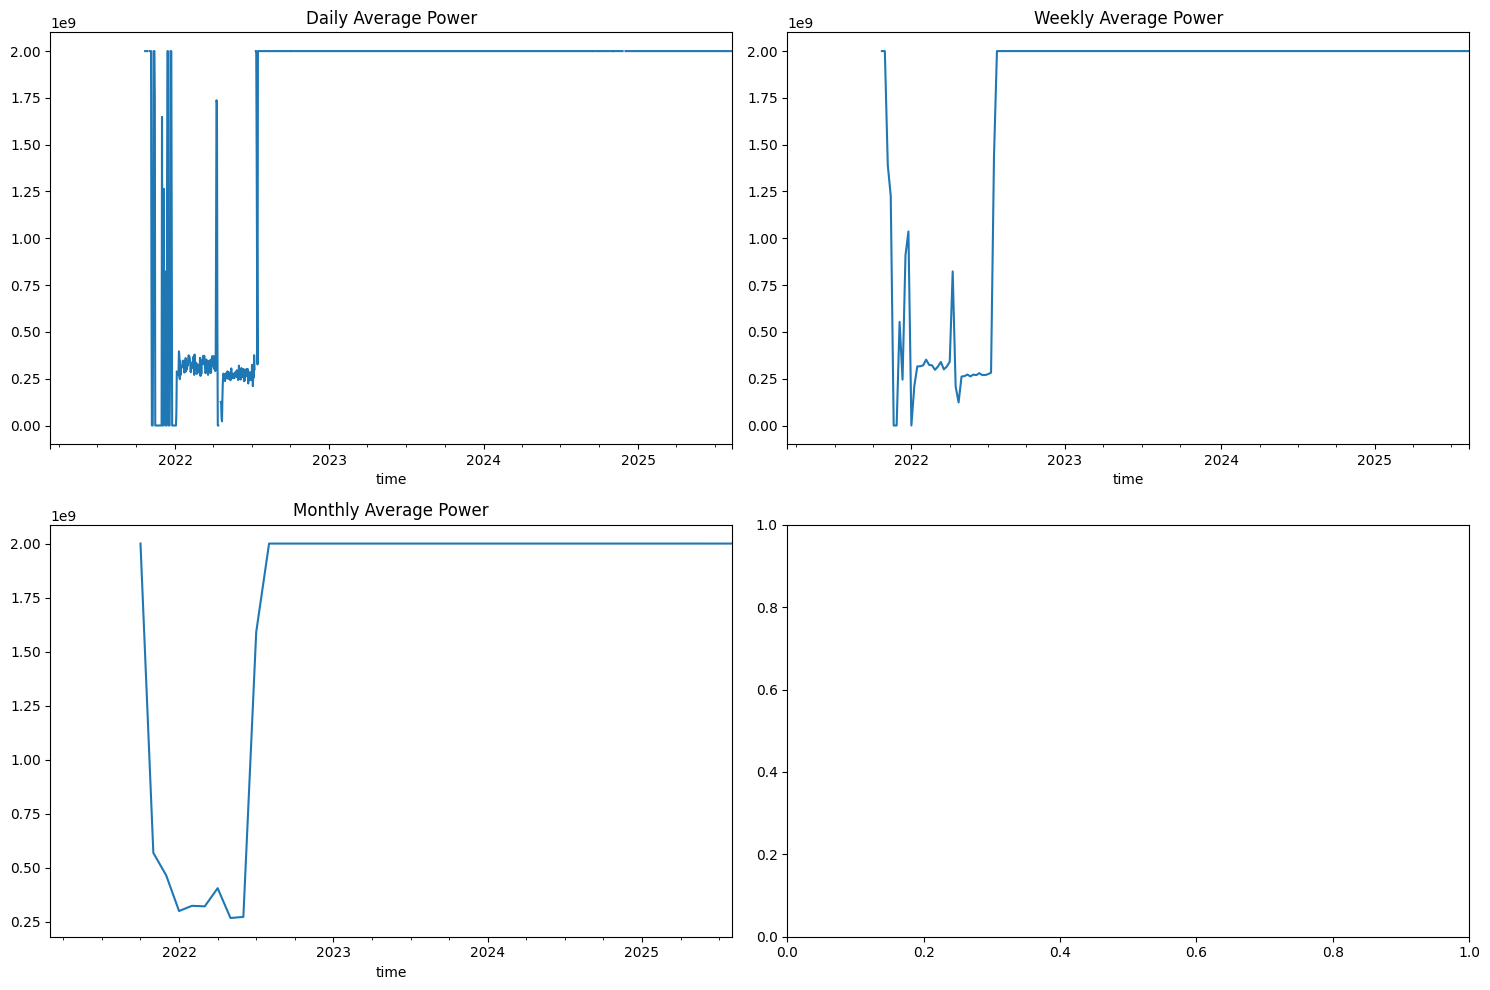

In [78]:
#we will now visualize the distribution of the ptot_watt column and then visualise it by different time aggregations
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values('time')
df.set_index('time')['ptot_watt'].resample('D').mean().plot(figsize=(12,5))
plt.title("Daily Total Power (Watt)")
plt.show()
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# daily time aggregate
df.set_index('time')['ptot_watt'].resample('D').mean().plot(ax=axes[0,0])
axes[0,0].set_title("Daily Average Power")

# weekly time aggregate
df.set_index('time')['ptot_watt'].resample('W').mean().plot(ax=axes[0,1])
axes[0,1].set_title("Weekly Average Power")

# monthly time aggregate
df.set_index('time')['ptot_watt'].resample('M').mean().plot(ax=axes[1,0])
axes[1,0].set_title("Monthly Average Power")


plt.tight_layout()
plt.show()

Lets try to pick up any presenting patterns

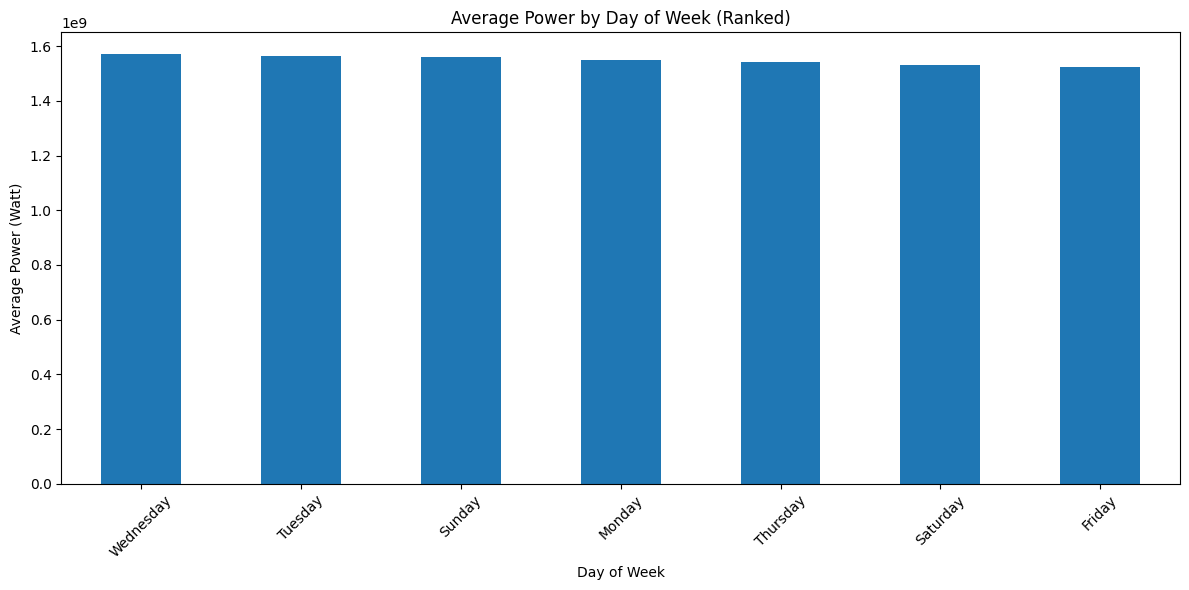

Average Power Consumption by Day (Ranked):
day_of_week
Wednesday    1.571692e+09
Tuesday      1.564109e+09
Sunday       1.558850e+09
Monday       1.547486e+09
Thursday     1.540303e+09
Saturday     1.531649e+09
Friday       1.523694e+09
Name: ptot_watt, dtype: float64


In [79]:
# the below code will help us visualize the average power consumption by day of the week, ranked from highest to lowest
df['day_of_week'] = df['time'].dt.day_name()

plt.figure(figsize=(12, 6))

# we will now calculate the mean power for each day and sort the values in descending order
sorted_series = df.groupby('day_of_week')['ptot_watt'].mean().sort_values(ascending=False)

# its time to visualise the ranked average power consumption by day of the week
sorted_series.plot(kind='bar')
plt.title("Average Power by Day of Week (Ranked)")
plt.xlabel("Day of Week")
plt.ylabel("Average Power (Watt)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# for the finer details, the below will write out the exact values of the ranked average power consumption by day of the week
print("Average Power Consumption by Day (Ranked):")
print(sorted_series)


Lets look for outliers, shall we?

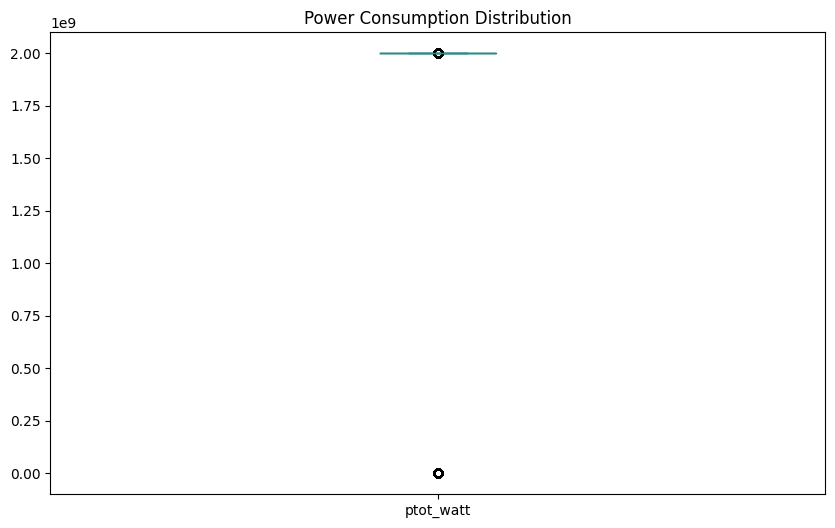

Number of outliers: 129916


In [80]:
# this will create a box plot for outliers
plt.figure(figsize=(10, 6))
df['ptot_watt'].plot(kind='box')
plt.title("Power Consumption Distribution")
plt.show()

# the following calculations will identify outliers statistically
Q1 = df['ptot_watt'].quantile(0.25)
Q3 = df['ptot_watt'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['ptot_watt'] < (Q1 - 1.5 * IQR)) | (df['ptot_watt'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers: {len(outliers)}")

What about trends?

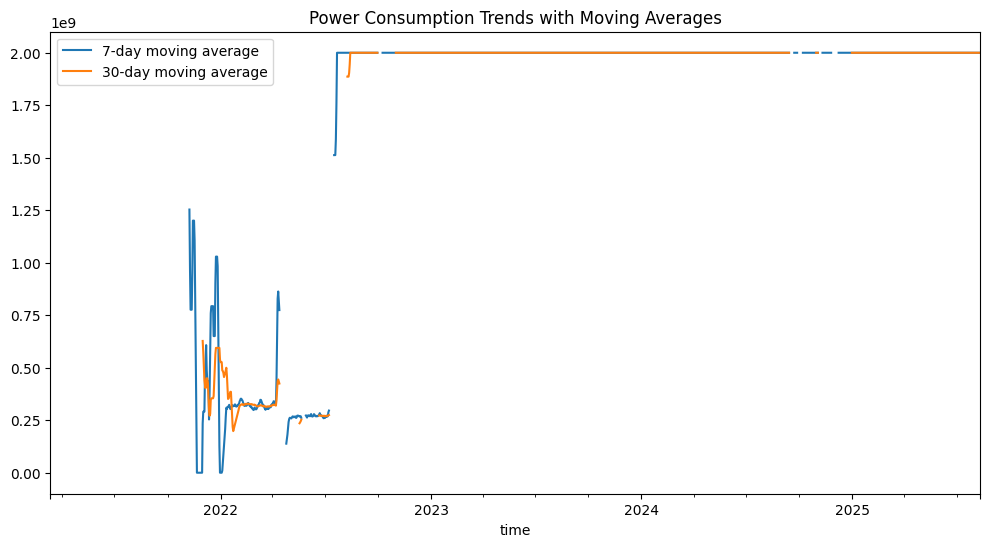

In [81]:
# we will now make use of rolling averages to see trends
plt.figure(figsize=(12, 6))
daily = df.set_index('time')['ptot_watt'].resample('D').mean()
daily.rolling(window=7).mean().plot(label='7-day moving average')
daily.rolling(window=30).mean().plot(label='30-day moving average')
plt.legend()
plt.title("Power Consumption Trends with Moving Averages")
plt.show()

What does our distribution look like?

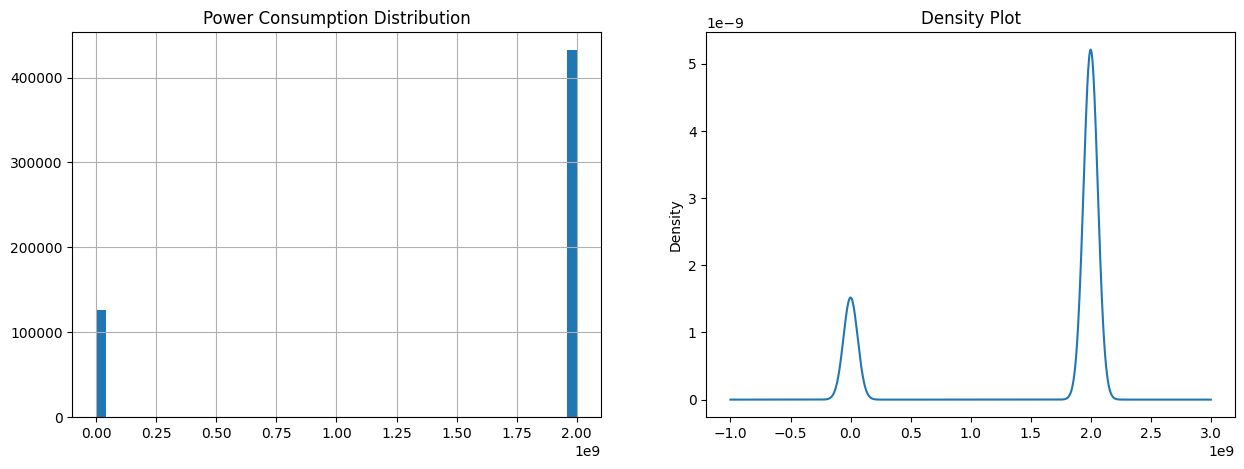

In [82]:
# we will make use of a histogram and a density plot to visualise the distribution of power consumption
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df['ptot_watt'].hist(bins=50, ax=axes[0])
axes[0].set_title("Power Consumption Distribution")

df['ptot_watt'].plot(kind='density', ax=axes[1])
axes[1].set_title("Density Plot")
plt.show()

We will now take a gander at the correlation heatmap

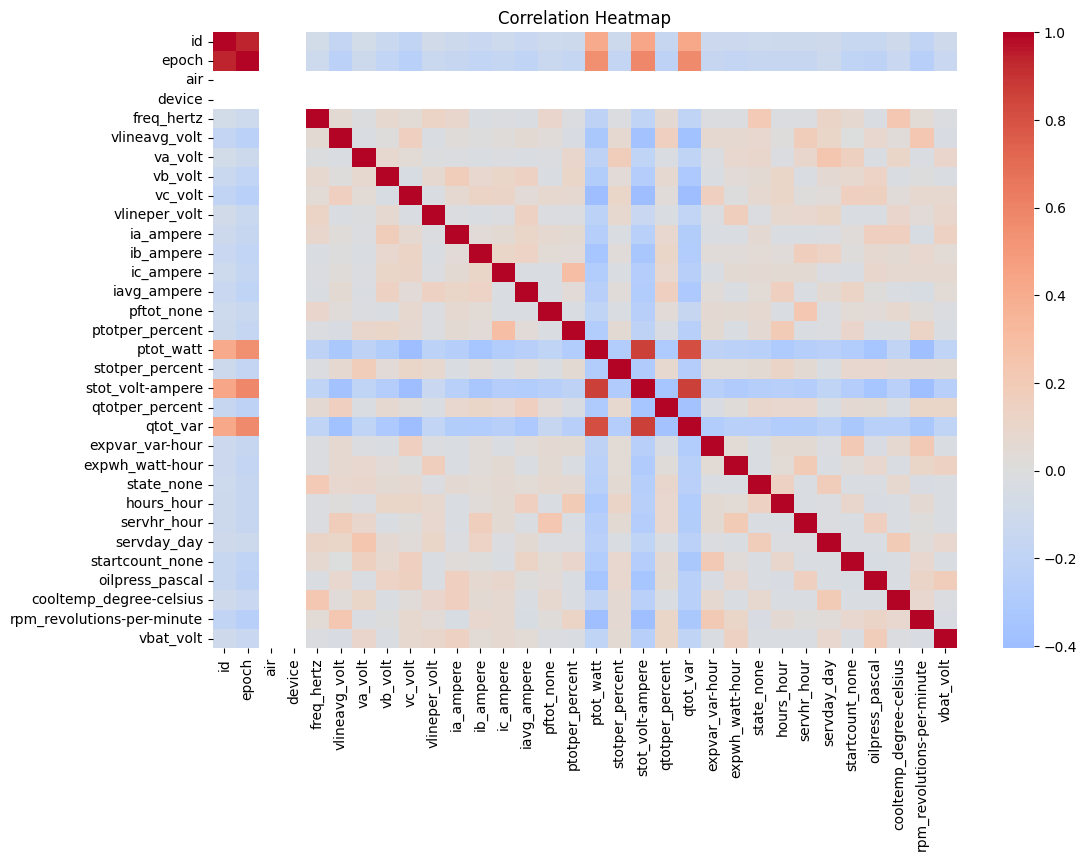

In [83]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

It is time for a statistical test


In [84]:
r, p = spearmanr(df['rpm_revolutions-per-minute'], df['ptot_watt'], nan_policy='omit')
print(f"Correlation RPM vs Power: r={r:.3f}, p={p:.3e}")

Correlation RPM vs Power: r=-0.637, p=0.000e+00


We will now finish off our data analysis with feature inclusion/exclusion

In [85]:
missing_thresh = 0.4
drop_missing = df.columns[df.isna().mean() > missing_thresh]

corr_matrix = corr.abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_corr = [column for column in upper.columns if any(upper[column] > 0.9)]

df = df.drop(columns=list(drop_missing) + drop_corr)
print("Dropped:", list(drop_missing) + drop_corr)

Dropped: ['epoch']


# Take Home:
This exploratory data analysis (EDA) offers a comprehensive understanding of the power consumption dataset, with each phase aimed at revealing specific insights. The process commenced by verifying data integrity: adjusting the 'time' column to a datetime format and arranging it chronologically to create a valid time series. Automated feature selection was subsequently employed to eliminate columns with a high rate of missing data (>40%), deemed unreliable, as well as those highly correlated with other features (>0.9), such as the superfluous 'epoch' time format, to reduce redundancy and enhance model reliability. The initial daily average visualization provides a broad perspective on overall consumption patterns, seasonality, and any noticeable long-term trends or abrupt changes. To further evaluate data quality, checks for missing values and summary statistics were computed to pinpoint gaps, anomalies, and to grasp the general distribution of power values. Various time aggregations (weekly, monthly) were then utilized to filter out daily noise and expose wider, more enduring trends that may be obscured by daily variations. Analyzing seasonal patterns, such as breaking down consumption by the day of the week, is essential for detecting periodic behavior, such as the differences between weekdays and weekends, which is crucial for forecasting and identifying anomalies. Outlier detection through box plots and the Interquartile Range (IQR) method assists in identifying unusual occurrences, meter inaccuracies, or periods of exceptional activity that might distort analysis or models. Trend analysis using moving averages further clarifies the fundamental direction of the data by mitigating short-term volatility. Lastly, assessing the distribution of power values via histograms and density plots confirms whether the data is normally distributed, skewed, or multimodal, which influences the selection of subsequent statistical models. Collectively, these steps convert raw time-stamped data into a coherent narrative about how, when, and how consistently power is consumed.
